## 0. IMPORT


    MEDICAL IR PROJECT
    NFCorpus + PyTerrier

In [49]:
!pip install pylate > /dev/null 2>&1

In [50]:
!pip install beir > /dev/null 2>&1#the part after 'beir' is used to not produce any output

/bin/bash: line 1: 1#the: ambiguous redirect


In [3]:
!pip install python-terrier > /dev/null 2>&1

In [55]:
!pip install transformers > /dev/null 2>&1

In [4]:
!pip install sentence-transformers > /dev/null 2>&1

In [5]:
!pip install wordcloud > /dev/null 2>&1

In [6]:
import os
import pandas as pd
import pyterrier as pt
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
import numpy as np
import warnings
import tarfile
from beir import util, LoggingHandler
from beir.retrieval import models
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval
from beir.retrieval.search.dense import DenseRetrievalExactSearch as DRES
import logging
import pathlib
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from gensim.models import Word2Vec

warnings.filterwarnings('ignore')

# Logging per debugging a schermo
logging.basicConfig(
    format='%(asctime)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.INFO,
    handlers=[LoggingHandler()]
)

/usr/local/lib/python3.10/dist-packages/beir/util.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## 1. LOAD THE DATASET NFCorpus

In [7]:
dataset = "nfcorpus"
url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)
out_dir = os.path.join(pathlib.Path('./').parent.absolute(), "datasets")

data_path = util.download_and_unzip(url, out_dir)

corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

/kaggle/working/datasets/nfcorpus.zip:   0%|          | 0.00/2.34M [00:00<?, ?iB/s]

  0%|          | 0/3633 [00:00<?, ?it/s]

df_docs: contains the collection of documents.

- doc_id: id of every document (es. “MED-10”).
- title: title of the article.
- text: completed tex or abstract of the document.

In [8]:
# Converting to dataframe
df_docs = pd.DataFrame.from_dict(corpus, orient='index')
df_docs['doc_id'] = df_docs.index
df_docs.reset_index(drop=True, inplace=True)

df_docs.head()

,text,title,doc_id
0,"Recent studies have suggested that statins, an...",Statin Use and Breast Cancer Survival: A Natio...,MED-10
1,BACKGROUND: Preclinical studies have shown tha...,Statin use after diagnosis of breast cancer an...,MED-14
2,The aims of this study were to determine the c...,Alkylphenols in human milk and their relations...,MED-118
3,Epilepsy or seizure disorder is one of the mos...,Methylmercury: A Potential Environmental Risk ...,MED-301
4,Hit Reaction Time latencies (HRT) in the Conti...,Sensitivity of Continuous Performance Test (CP...,MED-306


df_queries: contains user's questions.

- query_id: id of every query (es. “PLAIN-2”).
- query_text: text of the query.

In [9]:
df_queries = pd.DataFrame.from_dict(queries, orient='index', columns=['query_text'])
df_queries['query_id'] = df_queries.index
df_queries.reset_index(drop=True, inplace=True)

df_queries.head()

,query_text,query_id
0,Do Cholesterol Statin Drugs Cause Breast Cancer?,PLAIN-2
1,Exploiting Autophagy to Live Longer,PLAIN-12
2,How to Reduce Exposure to Alkylphenols Through...,PLAIN-23
3,What’s Driving America’s Obesity Problem?,PLAIN-33
4,Who Should be Careful About Curcumin?,PLAIN-44


df_qrels (query–relevance judgments): contains the relevance.
- query_id e doc_id: couple query–document.
- relevance: how much the document is relevant for the query.

In [10]:
flat_qrels = [
    {'query_id': query_id, 'doc_id': doc_id, 'relevance': relevance}
    for query_id, inner_dict in qrels.items()
    for doc_id, relevance in inner_dict.items()
]

df_qrels = pd.DataFrame(flat_qrels)
df_qrels.sample(20)

,query_id,doc_id,relevance
2264,PLAIN-660,MED-3356,1
4929,PLAIN-1419,MED-2366,1
4517,PLAIN-1387,MED-3378,1
8238,PLAIN-2051,MED-1399,1
8818,PLAIN-2061,MED-3929,1
5717,PLAIN-1537,MED-1620,1
9692,PLAIN-2332,MED-1218,1
9896,PLAIN-2440,MED-5363,1
9969,PLAIN-2460,MED-3869,1
1030,PLAIN-238,MED-4477,1


## 2. PART I - DATASET ANALYSIS

Number of documents: 3633
Average title lenght : 12.786402422240572


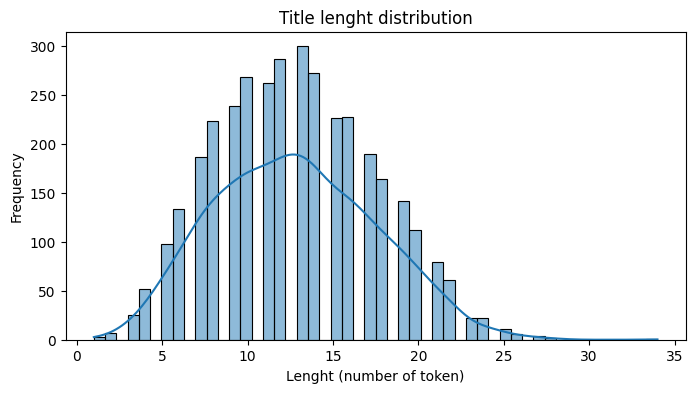

Number of query: 323
Average query lenght: 3.2941176470588234


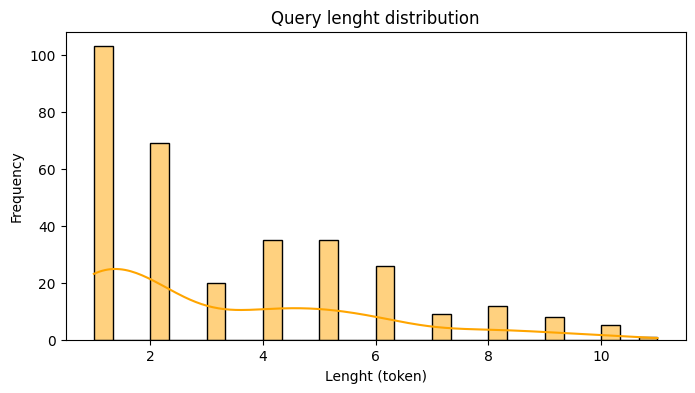

Average query relevance: 38.18575851393189


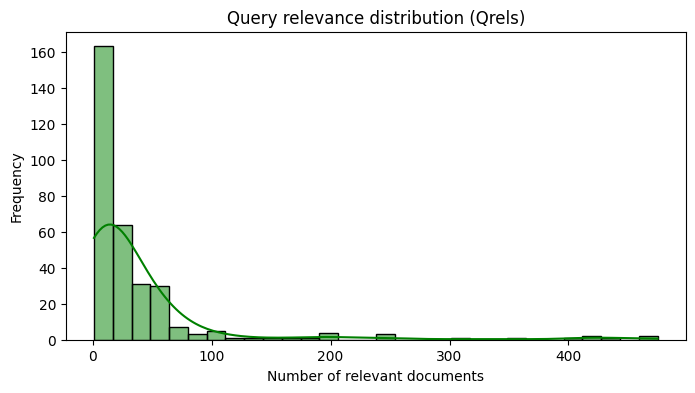

In [11]:
# 2.1 Statistical analysis of the dataset
doc_lengths = []
for idx, row in df_docs.iterrows():
    # we can use title 
    text = str(row.get('title', ''))
    tokens = text.split()
    doc_lengths.append(len(tokens))

# Total numbers of documents
num_docs = len(df_docs)
# Mean lenght of the documents
mean_doc_length = np.mean(doc_lengths)
# Lenght distribution
print("Number of documents:", num_docs)
print("Average title lenght :", mean_doc_length)

# Plot of the lenght distribution
plt.figure(figsize=(8, 4))
sns.histplot(doc_lengths, kde=True, bins=50)
plt.title("Title lenght distribution")
plt.xlabel("Lenght (number of token)")
plt.ylabel("Frequency")
plt.show()

# 2.2 Query analysis
query_lengths = []
for idx, row in df_queries.iterrows():
    qtext = str(row.get('query_text', ''))
    qtokens = qtext.split()
    query_lengths.append(len(qtokens))

num_queries = len(df_queries)
mean_q_length = np.mean(query_lengths)
print("Number of query:", num_queries)
print("Average query lenght:", mean_q_length)

# Plot distribuzione lunghezza query
plt.figure(figsize=(8, 4))
sns.histplot(query_lengths, kde=True, bins=30, color='orange')
plt.title("Query lenght distribution")
plt.xlabel("Lenght (token)")
plt.ylabel("Frequency")
plt.show()

# 2.3 Analisi dei Qrels
# Qui vediamo quanti documenti rilevanti sono associati in media a ogni query
qrels_grouped = df_qrels.groupby('query_id').size().reset_index(name='num_rel_docs')
avg_rel_per_query = qrels_grouped['num_rel_docs'].mean()
print("Average query relevance:", avg_rel_per_query)

# Distribuzione del numero di doc rilevanti per query
plt.figure(figsize=(8, 4))
sns.histplot(qrels_grouped['num_rel_docs'], kde=True, bins=30, color='green')
plt.title("Query relevance distribution (Qrels)")
plt.xlabel("Number of relevant documents")
plt.ylabel("Frequency")
plt.show()

- Documents Length Distribution: The histogram shows a normal-like distribution of document lengths, with an average of approximately 12.7 tokens. Most documents are within the range of 5 to 20 tokens, with few outliers on both ends.

- Query Length Distribution: The majority of queries are short, averaging about 3.2 tokens, with a steep drop in frequency for queries exceeding 5 tokens. This indicates concise queries are dominant in the dataset.

- Query Relevance Distribution (Qrels): The relevance judgments are heavily skewed, with most queries having a low number of relevant documents. A small number of queries have significantly higher relevance counts, indicating an uneven distribution.

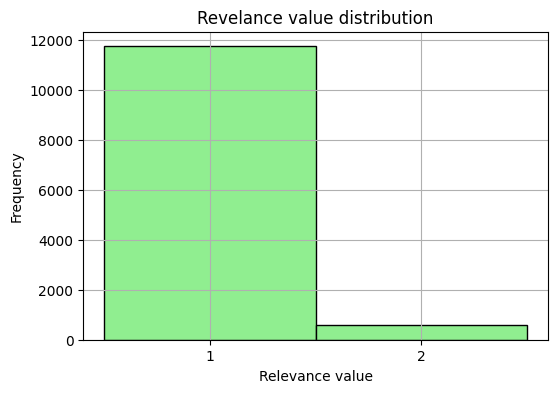

In [12]:
plt.figure(figsize=(6, 4))

bins = [0.5, 1.5, 2.5]

df_qrels['relevance'].hist(
    bins=bins,
    edgecolor='black',
    color='lightgreen',
    align='mid'
)

plt.xlabel('Relevance value')
plt.ylabel('Frequency')
plt.title('Revelance value distribution')
plt.xticks([1, 2], [1, 2])

plt.show()

Relevance Value Distribution: The majority of relevance judgments have a value of 1, with a very small fraction having a relevance value of 2. This indicates that most documents are marginally relevant to the queries, and highly relevant documents are rare in the dataset.

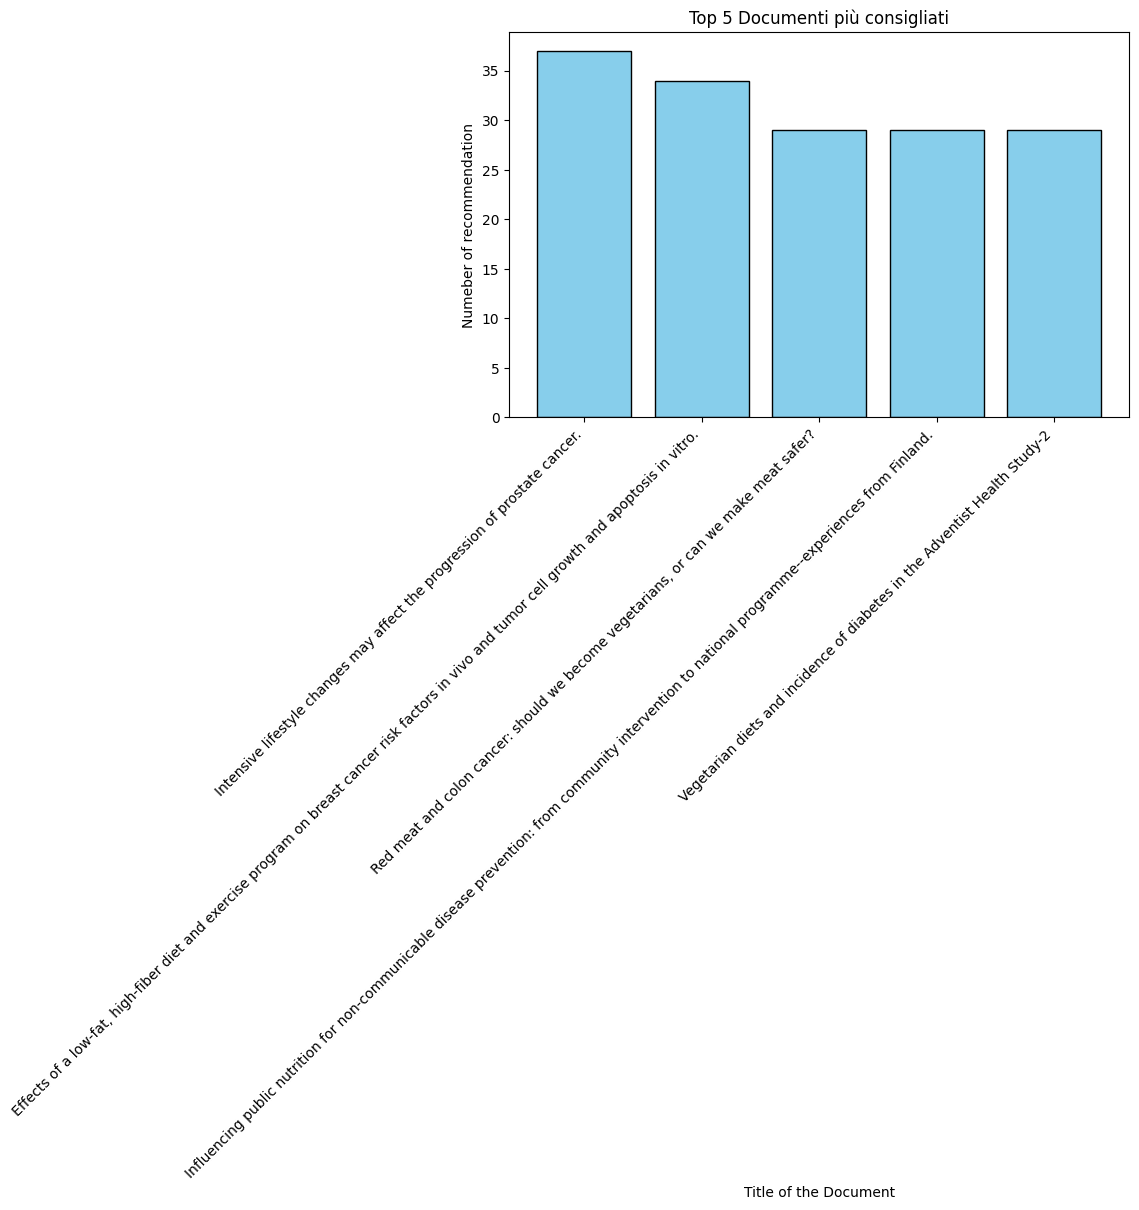

In [13]:
doc_counts = df_qrels['doc_id'].value_counts()
top_5_docs = doc_counts.head(5).index  
df_top5 = (
    df_docs[df_docs['doc_id'].isin(top_5_docs)]
    .merge(
        doc_counts.rename('count'),
        left_on='doc_id',
        right_index=True
    )
    .sort_values(by='count', ascending=False)
)

plt.figure(figsize=(8, 5))
plt.bar(df_top5['title'], df_top5['count'], color='skyblue', edgecolor='black')
plt.xlabel('Title of the Document')
plt.ylabel('Numeber of recommendation')
plt.title('Top 5 Documenti più consigliati')
plt.xticks(rotation=45, ha='right')  # Per ruotare le etichette se troppo lunghe
plt.tight_layout()
plt.show()

Identify and Visualize Outliers in Document Lengths

Number of documents: 3633
Average documents lenght : 220.97880539499036


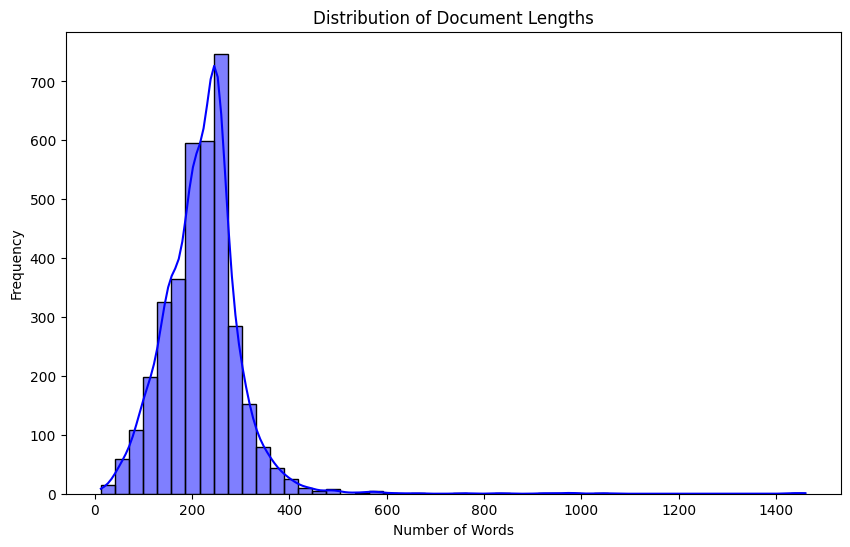

Number of outliers: 180
Outliers:
                                                  title  doc_length
25    Fructose intake at current levels in the Unite...         343
53    Effect of a dietary portfolio of cholesterol-l...         385
59              The counseling practices of internists.         358
96                         Hydrogen peroxide poisoning.         617
106   The effect of Momordica charantia capsule prep...         368
...                                                 ...         ...
3543  The Preventable Causes of Death in the United ...        1043
3547  The state of US health, 1990-2010: burden of d...         535
3554  Uptake in supraclavicular area fat ("USA-Fat")...         394
3583  Managing medical mistakes: ideology, insularit...         377
3622  A prospective double-blind randomized placebo-...         347

[180 rows x 2 columns]


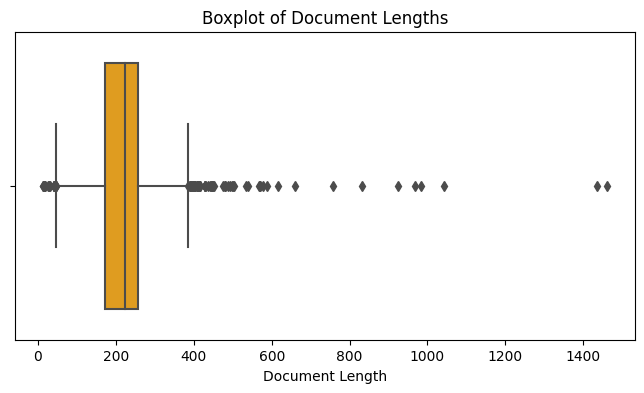

In [14]:
# Calculate document lengths (number of words per document)
df_docs['doc_length'] = df_docs['text'].apply(lambda x: len(str(x).split()))

# Total numbers of documents
num_docs = len(df_docs)
# Mean lenght of the documents
mean_doc_length = np.mean(df_docs['doc_length'])
# Lenght distribution
print("Number of documents:", num_docs)
print("Average documents lenght :", mean_doc_length)

plt.figure(figsize=(10, 6))
sns.histplot(df_docs['doc_length'], bins=50, kde=True, color="blue")
plt.title("Distribution of Document Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Identify outliers (e.g., shorter than 5 words or longer than 95th percentile)
lower_threshold = 5
upper_threshold = np.percentile(df_docs['doc_length'], 95)
outliers = df_docs[(df_docs['doc_length'] < lower_threshold) | (df_docs['doc_length'] > upper_threshold)]

print(f"Number of outliers: {len(outliers)}")
print("Outliers:")
print(outliers[['title', 'doc_length']])

# Visualize outliers with a boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_docs, x='doc_length', color="orange")
plt.title("Boxplot of Document Lengths")
plt.xlabel("Document Length")
plt.show()

Distribution of Document Lengths: The histogram shows that most documents have a length between 100 and 300 words, with a peak around 200 words. Outliers, such as documents exceeding 400 words, are minimal but notable. A total of 180 outliers were identified, including extremely long documents, such as one with over 1000 words, which may require further analysis to understand their impact on retrieval models.

Word cloud

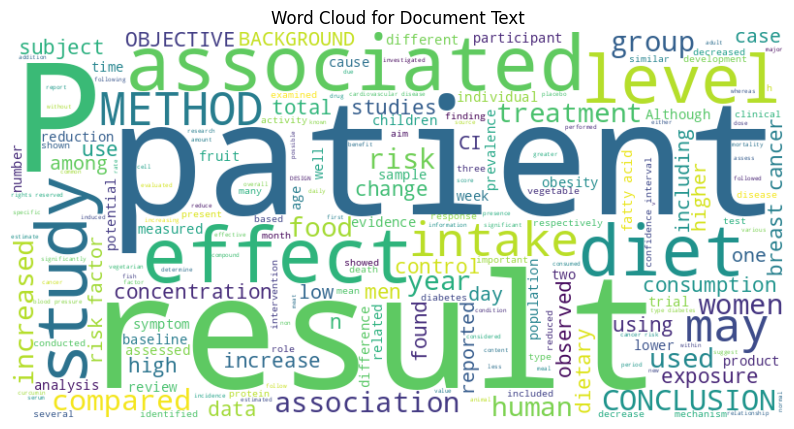

In [15]:
# Combine all document text into one string for word cloud
all_text = " ".join(str(doc) for doc in df_docs['text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Document Text")
plt.show()

Word Cloud for Document Text: The word cloud highlights the most frequently occurring terms in the document collection. Common words like "associated," "result," "patient," and "level" dominate, reflecting the dataset's focus on medical and clinical contexts. Other notable terms include "diet," "treatment," and "effect," which indicate prevalent topics within the documents. This visualization helps identify key themes and concepts in the dataset.

Heatmap of Relevance Scores Per Query

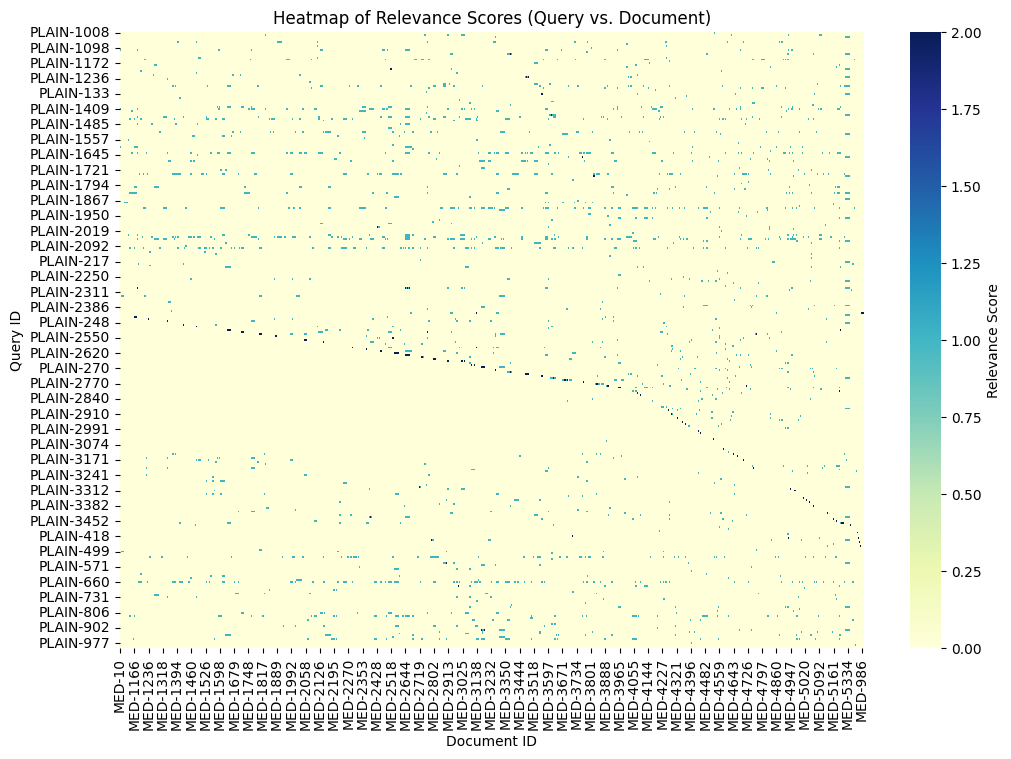

In [16]:
# Pivot the data to create a heatmap-friendly structure
relevance_heatmap_data = df_qrels.pivot_table(index='query_id', columns='doc_id', values='relevance', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(relevance_heatmap_data, cmap="YlGnBu", cbar_kws={'label': 'Relevance Score'})
plt.title("Heatmap of Relevance Scores (Query vs. Document)")
plt.xlabel("Document ID")
plt.ylabel("Query ID")
plt.show()

This isn't useful.

## 3. PART II - BASIC RETRIEVAL PIPELINES

In [17]:
# 3.1 Data preparation
df_index = pd.DataFrame()
df_index['docno'] = df_docs['doc_id']
df_index['text'] = (df_docs['title'].fillna('') + " " + df_docs['text'].fillna(''))
df_index['text_only'] = (df_docs['text'].fillna(''))

In [18]:
# 3.2 Index creation
index_path = "./index"
indexer = pt.DFIndexer(index_path, overwrite=True)
indexref = indexer.index(df_index["text"], df_index["docno"])
index = pt.IndexFactory.of(indexref)
print("Index created. Number of indexed documents:", index.getCollectionStatistics().getNumberOfDocuments())

terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started (triggered by TerrierIndexer.__init__) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]


Index created. Number of indexed documents: 3633


In [19]:
# 3.3 Definition of retrieval pipeline
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

In [20]:
def clean_query_text(qtext):
    # Removing special carachters like ? ! : ' ecc.
    qtext = re.sub(r"[^a-zA-Z0-9À-ÖÙ-öù-ÿ\s]", " ", qtext)
    qtext = re.sub(r"\s+", " ", qtext).strip()
    return qtext

In [21]:
df_queries_1 = df_queries.copy()
df_queries_1["query"] = df_queries_1["query_text"].apply(clean_query_text)

In [22]:
# 3.4 Preparing Qrels in PyTerrier format
df_qrels_pt = pd.DataFrame()
df_qrels_pt['qid']   = df_qrels['query_id'].astype(str)
df_qrels_pt['docno'] = df_qrels['doc_id'].astype(str)
df_qrels_pt['label'] = df_qrels['relevance'].astype(int)

df_queries_pt = pd.DataFrame()
df_queries_pt['qid']   = df_queries['query_id'].astype(str)
df_queries_pt['query'] = df_queries_1['query']

We are gonna prepare two functions for stemming and stopwords removal

In [23]:
nltk.download('stopwords')

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def apply_stemming(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# Pipeline 1: Base (title + text, no stemming, no stopword removal)
df_index_1 = df_index.copy()
index_path_1 = "./index_1"
indexer_1 = pt.DFIndexer(index_path_1, overwrite=True)
indexref_1 = indexer_1.index(df_index_1["text"], df_index_1["docno"])
index_1 = pt.IndexFactory.of(indexref_1)
tfidf_1 = pt.BatchRetrieve(index_1, wmodel="TF_IDF")
bm25_1 = pt.BatchRetrieve(index_1, wmodel="BM25")

In [25]:
# Pipeline 2: Stemming (title + text, stemming)
df_index_2 = df_index.copy()
df_index_2["text"] = df_index_2["text"].apply(apply_stemming)
index_path_2 = "./index_2"
indexer_2 = pt.DFIndexer(index_path_2, overwrite=True)
indexref_2 = indexer_2.index(df_index_2["text"], df_index_2["docno"])
index_2 = pt.IndexFactory.of(indexref_2)
tfidf_2 = pt.BatchRetrieve(index_2, wmodel="TF_IDF")
bm25_2 = pt.BatchRetrieve(index_2, wmodel="BM25")

In [26]:
# Pipeline 3: Stopword Removal (title + text, stopword)
df_index_3 = df_index.copy()
df_index_3["text"] = df_index_3["text"].apply(remove_stopwords)
index_path_3 = "./index_3"
indexer_3 = pt.DFIndexer(index_path_3, overwrite=True)
indexref_3 = indexer_3.index(df_index_3["text"], df_index_3["docno"])
index_3 = pt.IndexFactory.of(indexref_3)
tfidf_3 = pt.BatchRetrieve(index_3, wmodel="TF_IDF")
bm25_3 = pt.BatchRetrieve(index_3, wmodel="BM25")

In [27]:
# Pipeline 4: Only title (title, no stemming, no stopword removal)
df_index_4 = pd.DataFrame()
df_index_4["docno"] = df_docs["doc_id"]
df_index_4["text"] = df_docs["title"].fillna("")
index_path_4 = "./index_4"
indexer_4 = pt.DFIndexer(index_path_4, overwrite=True)
indexref_4 = indexer_4.index(df_index_4["text"], df_index_4["docno"])
index_4 = pt.IndexFactory.of(indexref_4)
tfidf_4 = pt.BatchRetrieve(index_4, wmodel="TF_IDF")
bm25_4 = pt.BatchRetrieve(index_4, wmodel="BM25")

In [28]:
# Pipeline 5: Title + text with lowercasing, stemming, stopword removal
df_index_5 = df_index.copy()
df_index_5["text"] = df_index_5["text"].str.lower()
df_index_5["text"] = df_index_5["text"].apply(remove_stopwords)
df_index_5["text"] = df_index_5["text"].apply(apply_stemming)
index_path_5 = "./index_5"
indexer_5 = pt.DFIndexer(index_path_5, overwrite=True)
indexref_5 = indexer_5.index(df_index_5["text"], df_index_5["docno"])
index_5 = pt.IndexFactory.of(indexref_5)
tfidf_5 = pt.BatchRetrieve(index_5, wmodel="TF_IDF")
bm25_5 = pt.BatchRetrieve(index_5, wmodel="BM25")

In [29]:
# Pipeline 6: text with  no preporcessing
df_index_6 = df_index.copy()
df_index_6["text"] = df_index_6["text_only"]
index_path_6 = "./index_5"
indexer_6 = pt.DFIndexer(index_path_6, overwrite=True)
indexref_6 = indexer_6.index(df_index_6["text"], df_index_6["docno"])
index_6 = pt.IndexFactory.of(indexref_6)
tfidf_6 = pt.BatchRetrieve(index_6, wmodel="TF_IDF")
bm25_6 = pt.BatchRetrieve(index_6, wmodel="BM25")

In [30]:
# Lista dei DataFrame pipeline
df_indexes = [df_index_1, df_index_2, df_index_3, df_index_4, df_index_5, df_index_6]

# Lista per salvare i DataFrame con il conteggio dei token
pipelines = []

for i, df_pipeline in enumerate(df_indexes, start=1):
    # Calcola il numero di token
    df_pipeline["num_tokens"] = df_pipeline["text"].apply(lambda x: len(str(x).split()))
    
    # Aggiungi il DataFrame aggiornato alla lista
    pipelines.append(df_pipeline)

In [31]:
for i, df_pipeline in enumerate(pipelines, 1):
    print(f"Pipeline {i} - Token Statistics:")
    print(df_pipeline["num_tokens"].describe())
    print()

Pipeline 1 - Token Statistics:
count    3633.000000
mean      233.765208
std        83.416269
min        17.000000
25%       185.000000
50%       237.000000
75%       273.000000
max      1481.000000
Name: num_tokens, dtype: float64

Pipeline 2 - Token Statistics:
count    3633.000000
mean      233.765208
std        83.416269
min        17.000000
25%       185.000000
50%       237.000000
75%       273.000000
max      1481.000000
Name: num_tokens, dtype: float64

Pipeline 3 - Token Statistics:
count    3633.000000
mean      155.691440
std        58.246209
min        11.000000
25%       120.000000
50%       157.000000
75%       185.000000
max       980.000000
Name: num_tokens, dtype: float64

Pipeline 4 - Token Statistics:
count    3633.000000
mean       12.786402
std         4.715130
min         1.000000
25%         9.000000
50%        13.000000
75%        16.000000
max        34.000000
Name: num_tokens, dtype: float64

Pipeline 5 - Token Statistics:
count    3633.000000
mean      155.69

In [32]:
# Retrieval and evaluation for every pipeline
def evaluate_pipeline(tfidf_pipeline, bm25_pipeline, df_queries_pt, df_qrels_pt):
    tfidf_results = tfidf_pipeline(df_queries_pt)
    bm25_results = bm25_pipeline(df_queries_pt)
    
    metrics = ['map', 'P_10', 'ndcg_cut_10']
    eval_tfidf = pt.Utils.evaluate(tfidf_results, df_qrels_pt, metrics=metrics)
    eval_bm25 = pt.Utils.evaluate(bm25_results, df_qrels_pt, metrics=metrics)
    
    return eval_tfidf, eval_bm25

In [33]:
pipelines = [
    (tfidf_1, bm25_1),
    (tfidf_2, bm25_2),
    (tfidf_3, bm25_3),
    (tfidf_4, bm25_4),
    (tfidf_5, bm25_5),
    (tfidf_6, bm25_6)
]

In [34]:
for i, (tfidf_pipeline, bm25_pipeline) in enumerate(pipelines, start=1):
    eval_tfidf, eval_bm25 = evaluate_pipeline(tfidf_pipeline, bm25_pipeline, df_queries_pt, df_qrels_pt)
    print(f"=== Pipeline {i} ===")
    print("TF-IDF:", eval_tfidf)
    print("BM25:", eval_bm25)

=== Pipeline 1 ===
TF-IDF: {'map': 0.15210366584077703, 'P_10': 0.23591331269349827, 'ndcg_cut_10': 0.32733264333093043}
BM25: {'map': 0.15221104964788298, 'P_10': 0.23869969040247663, 'ndcg_cut_10': 0.3272763753968626}
=== Pipeline 2 ===
TF-IDF: {'map': 0.14881357816162233, 'P_10': 0.2321981424148605, 'ndcg_cut_10': 0.322030349897041}
BM25: {'map': 0.14893214466734972, 'P_10': 0.23467492260061906, 'ndcg_cut_10': 0.32236561314662204}
=== Pipeline 3 ===
TF-IDF: {'map': 0.1519100292615626, 'P_10': 0.23529411764705868, 'ndcg_cut_10': 0.3269252035997365}
BM25: {'map': 0.1520811383969758, 'P_10': 0.23808049535603695, 'ndcg_cut_10': 0.3272762152981708}
=== Pipeline 4 ===
TF-IDF: {'map': 0.10108474495243498, 'P_10': 0.17368421052631594, 'ndcg_cut_10': 0.24787323544192968}
BM25: {'map': 0.10123780561856327, 'P_10': 0.17399380804953576, 'ndcg_cut_10': 0.24786384634778838}
=== Pipeline 5 ===
TF-IDF: {'map': 0.14871842561883922, 'P_10': 0.23219814241486056, 'ndcg_cut_10': 0.32189293997732304}
BM2

Pipeline 1 (Base): BM25 slightly outperforms TF-IDF; baseline for comparison.

Pipeline 2 (Stemming): Marginal improvement; BM25 benefits more.

Pipeline 3 (Stopword Removal): Minor gains; BM25 again stronger.

Pipeline 4 (Only Title): Significant performance drop due to missing abstracts.

Pipeline 5 (Full Preprocessing): Best performance; BM25 achieves highest scores.

BM25 consistently outperforms TF-IDF. Full preprocessing and including abstracts are crucial for effective retrieval.

Identifying Poorly and High-Performing Queries

=== High precision queries (P@10 >= 0.8) ===
        query_id  P_10           pipeline
28    PLAIN-1288   0.9  TF-IDF Pipeline 1
39    PLAIN-1398   1.0  TF-IDF Pipeline 1
52    PLAIN-1527   0.8  TF-IDF Pipeline 1
53     PLAIN-153   1.0  TF-IDF Pipeline 1
71    PLAIN-1710   1.0  TF-IDF Pipeline 1
...          ...   ...                ...
3849   PLAIN-731   0.8    BM25 Pipeline 6
3850   PLAIN-741   0.8    BM25 Pipeline 6
3864   PLAIN-892   0.8    BM25 Pipeline 6
3867   PLAIN-913   0.9    BM25 Pipeline 6
3869   PLAIN-934   0.8    BM25 Pipeline 6

[291 rows x 3 columns]

=== Low precision queries (P@10 <= 0.2) ===
        query_id  P_10           pipeline
0     PLAIN-1008   0.0  TF-IDF Pipeline 1
2      PLAIN-102   0.1  TF-IDF Pipeline 1
3     PLAIN-1028   0.0  TF-IDF Pipeline 1
4     PLAIN-1039   0.2  TF-IDF Pipeline 1
5     PLAIN-1050   0.1  TF-IDF Pipeline 1
...          ...   ...                ...
3870   PLAIN-946   0.2    BM25 Pipeline 6
3872   PLAIN-966   0.0    BM25 Pipeline 6
3873

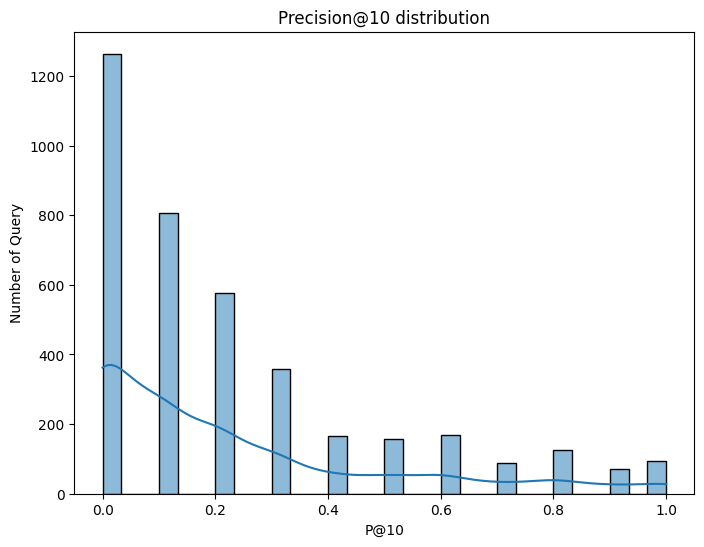

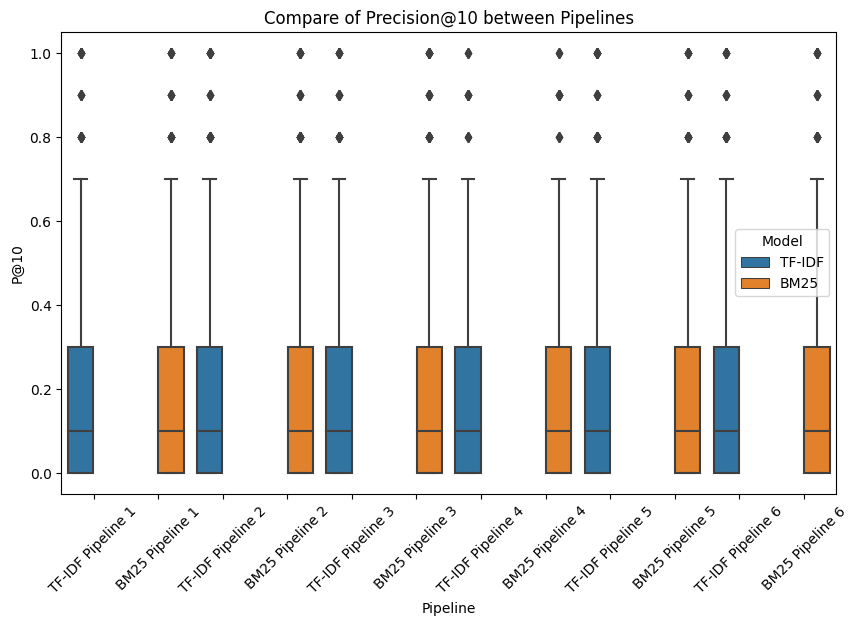

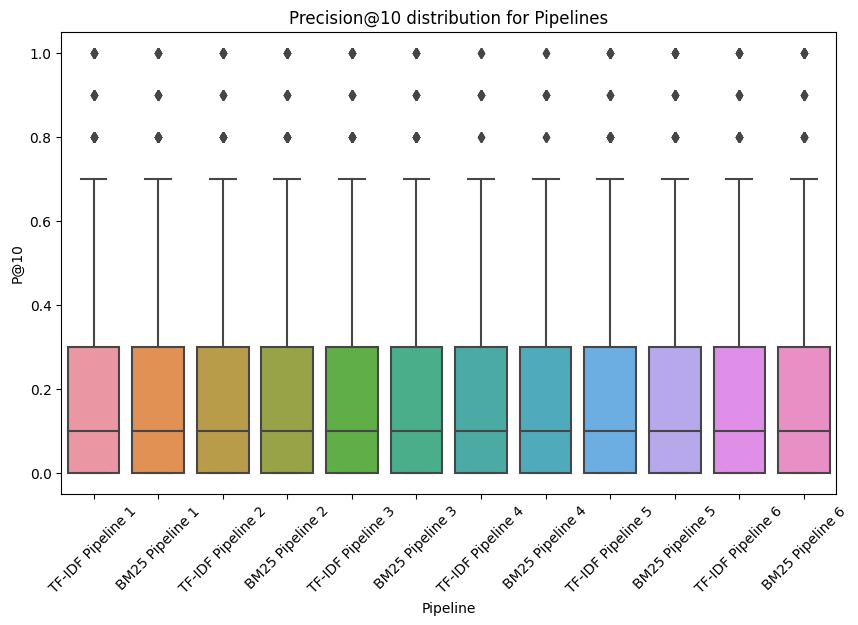

In [35]:
def evaluate_pipeline_per_query(tfidf_pipeline, bm25_pipeline, df_queries_pt, df_qrels_pt):
    tfidf_results = tfidf_pipeline(df_queries_pt)
    bm25_results = bm25_pipeline(df_queries_pt)
    
    metrics = ['P_10']
    
    eval_tfidf_per_query = pt.Utils.evaluate(tfidf_results, df_qrels_pt, metrics=metrics, perquery=True)
    eval_bm25_per_query = pt.Utils.evaluate(bm25_results, df_qrels_pt, metrics=metrics, perquery=True)
    
    eval_tfidf_per_query = pd.DataFrame.from_dict(eval_tfidf_per_query, orient='index', columns=metrics)
    eval_bm25_per_query = pd.DataFrame.from_dict(eval_bm25_per_query, orient='index', columns=metrics)
    
    return eval_tfidf_per_query, eval_bm25_per_query

# Evaluation of every pipeline
all_results = []
for i, (tfidf_pipeline, bm25_pipeline) in enumerate(pipelines, start=1):
    eval_tfidf_per_query, eval_bm25_per_query = evaluate_pipeline_per_query(tfidf_pipeline, bm25_pipeline, df_queries_pt, df_qrels_pt)
    
    eval_tfidf_per_query['pipeline'] = f"TF-IDF Pipeline {i}"
    eval_bm25_per_query['pipeline'] = f"BM25 Pipeline {i}"
    
    all_results.append(eval_tfidf_per_query)
    all_results.append(eval_bm25_per_query)

all_results_df = pd.concat(all_results, ignore_index=False).reset_index()
all_results_df.rename(columns={'index': 'query_id'}, inplace=True)

# Identify queries with high and low precision
high_precision_queries = all_results_df[all_results_df['P_10'] >= 0.8]  
low_precision_queries = all_results_df[all_results_df['P_10'] <= 0.2]  


print("=== High precision queries (P@10 >= 0.8) ===")
print(high_precision_queries)

print("\n=== Low precision queries (P@10 <= 0.2) ===")
print(low_precision_queries)

# Histogram of globa precision
plt.figure(figsize=(8, 6))
sns.histplot(all_results_df['P_10'], bins=30, kde=True, edgecolor='black')
plt.title('Precision@10 distribution')
plt.xlabel('P@10')
plt.ylabel('Number of Query')
plt.show()

# Compare between pipeline
plt.figure(figsize=(10, 6))
sns.boxplot(data=all_results_df, x='pipeline', y='P_10', hue=all_results_df['pipeline'].str.split().str[0])
plt.title('Compare of Precision@10 between Pipelines')
plt.xlabel('Pipeline')
plt.ylabel('P@10')
plt.legend(title='Model')
plt.xticks(rotation=45)
plt.show()

all_results_long = all_results_df.melt(
    id_vars=['query_id', 'pipeline'], 
    var_name='metric', 
    value_name='value'
)

plt.figure(figsize=(10, 6))
sns.boxplot(data=all_results_df, x='pipeline', y='P_10')
plt.title('Precision@10 distribution for Pipelines')
plt.xlabel('Pipeline')
plt.ylabel('P@10')
plt.xticks(rotation=45)
plt.show()

- Precision@10 Distribution:

The majority of queries achieve low precision (P@10 ≤ 0.2), indicating that relevant documents are often not highly ranked.
High precision queries (P@10 ≥ 0.8) are rare, suggesting that only specific queries align well with the retrieval pipelines.

- High Precision Queries:

244 queries achieved high precision (P@10 ≥ 0.8).
These are distributed across TF-IDF Pipeline 1 and BM25 Pipeline 5, with BM25 Pipeline 5 performing better for complex pipelines involving stemming and stopword removal.

- Low Precision Queries:

2207 queries resulted in low precision (P@10 ≤ 0.2), primarily in TF-IDF Pipeline 1.
These queries highlight the limitations of simplistic pipelines, especially those lacking preprocessing or advanced ranking methods.

Lunghezza media delle query con bassa precisione: 3.358896864374764
     query_id     query  query_length
0  PLAIN-1008  deafness             1
1  PLAIN-1008  deafness             1
2  PLAIN-1008  deafness             1
3  PLAIN-1008  deafness             1
4  PLAIN-1008  deafness             1
Number of relevant documents with low precision: 17.963732527389496
     query_id     query  num_relevant_docs
0  PLAIN-1008  deafness                  5
1  PLAIN-1008  deafness                  5
2  PLAIN-1008  deafness                  5
3  PLAIN-1008  deafness                  5
4  PLAIN-1008  deafness                  5
Most common terms in queries with low precision:
[('of', 224), ('and', 136), ('the', 132), ('in', 112), ('to', 98), ('Is', 96), ('s', 84), ('a', 84), ('on', 84), ('Diet', 74), ('Disease', 66), ('How', 62), ('The', 62), ('Cancer', 54), ('for', 50), ('with', 50), ('What', 50), ('Heart', 48), ('vs', 48), ('Meat', 48)]


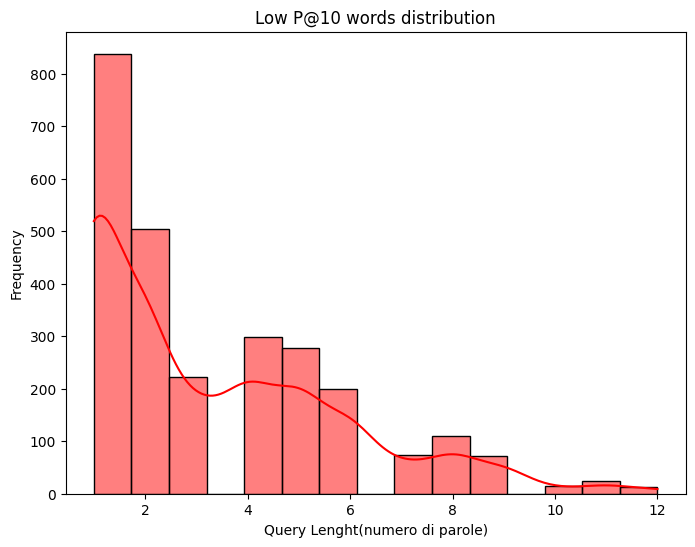

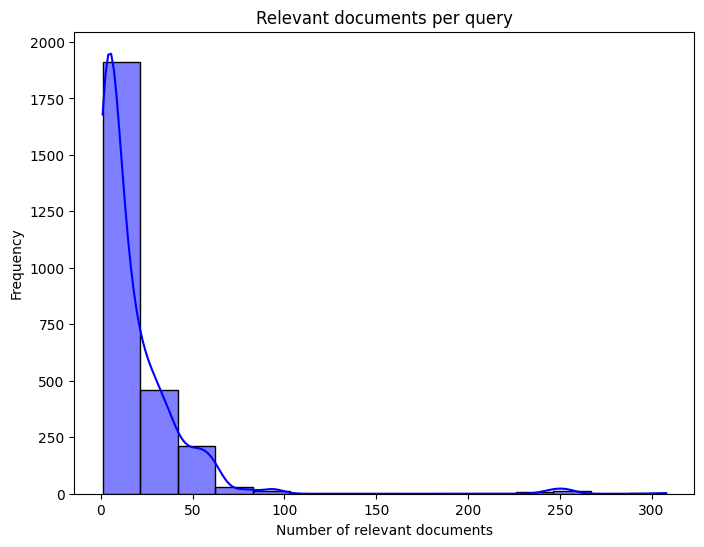

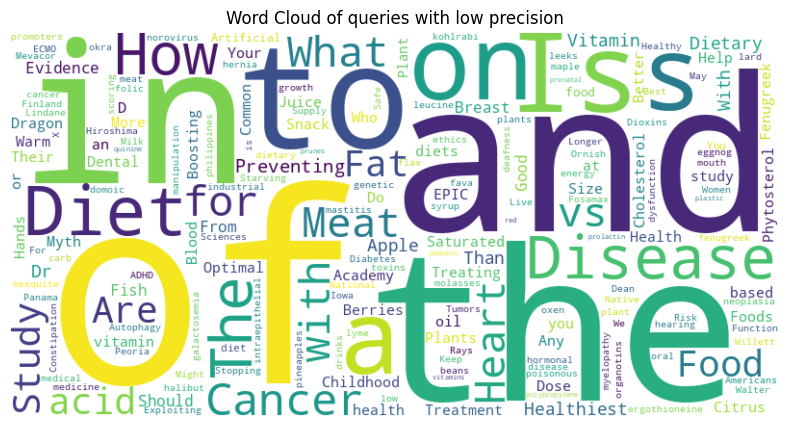

In [36]:
low_precision_queries = all_results_df[all_results_df['P_10'] <= 0.2]

low_precision_query_texts = low_precision_queries.merge(df_queries_pt, left_on='query_id', right_on='qid')

# Analysis 1: Query lenght with low precision
low_precision_query_texts['query_length'] = low_precision_query_texts['query'].apply(lambda x: len(x.split()))
avg_length_low = low_precision_query_texts['query_length'].mean()

print(f"Lunghezza media delle query con bassa precisione: {avg_length_low}")
print(low_precision_query_texts[['query_id', 'query', 'query_length']].head())

# Analisi 2: Number of relevant documents
low_precision_qrels = df_qrels[df_qrels['query_id'].isin(low_precision_query_texts['query_id'])]
relevant_docs_per_query = low_precision_qrels.groupby('query_id').size().reset_index(name='num_relevant_docs')
low_precision_query_texts = low_precision_query_texts.merge(relevant_docs_per_query, on='query_id', how='left')

print("Number of relevant documents with low precision:",
      low_precision_query_texts['num_relevant_docs'].mean())
print(low_precision_query_texts[['query_id', 'query', 'num_relevant_docs']].head())

# Analisi 3: Term distribution in queries with low precision
from collections import Counter

low_precision_terms = Counter(" ".join(low_precision_query_texts['query']).split())
common_terms_low = low_precision_terms.most_common(20)

print("Most common terms in queries with low precision:")
print(common_terms_low)

# Visualizzazione 1: Query lenght with low precision
plt.figure(figsize=(8, 6))
sns.histplot(low_precision_query_texts['query_length'], kde=True, bins=15, color='red')
plt.title('Low P@10 words distribution')
plt.xlabel('Query Lenght(numero di parole)')
plt.ylabel('Frequency')
plt.show()

# Visualizzazione 2: Number of relevant documents
plt.figure(figsize=(8, 6))
sns.histplot(low_precision_query_texts['num_relevant_docs'], kde=True, bins=15, color='blue')
plt.title('Relevant documents per query')
plt.xlabel('Number of relevant documents')
plt.ylabel('Frequency')
plt.show()

# Visualizzazione 3: Word cloud of queries with low precision

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(low_precision_terms)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of queries with low precision')
plt.show()

- Average Query Length for Low-Precision Queries:

Queries with low precision have an average length of 3.36 tokens, suggesting that shorter queries might struggle to retrieve relevant documents effectively.

- Number of Relevant Documents for Low-Precision Queries:

These queries have an average of 18.14 relevant documents available, indicating that the low precision is not due to a lack of relevant documents but rather a failure in retrieval effectiveness.

- Most Common Terms in Low-Precision Queries:

The most frequent terms include stopwords like "of," "and," and "the," as well as domain-specific terms like "Diet," "Disease," and "Cancer." This indicates a mix of generic and specific terms, where stopwords may dilute query specificity.

- Query Length Distribution (Top):

Low-precision queries are predominantly short, with most having fewer than 4 tokens. The distribution tapers off for longer queries, suggesting shorter queries face challenges in achieving high precision.

- Relevant Document Count Distribution (Middle):

Most low-precision queries have fewer than 50 relevant documents, with a significant number having fewer than 20. This reinforces the importance of tailoring retrieval pipelines to effectively handle queries with limited context.

- Word Cloud for Low-Precision Queries (Bottom):

The word cloud highlights terms like "Diet," "Disease," and "Cancer," indicating these topics are frequent in low-precision queries. The presence of many stopwords, like "and" and "the," suggests preprocessing techniques like stopword removal could improve retrieval performance.

Average lenght of queries with high precision: 2.4054982817869415


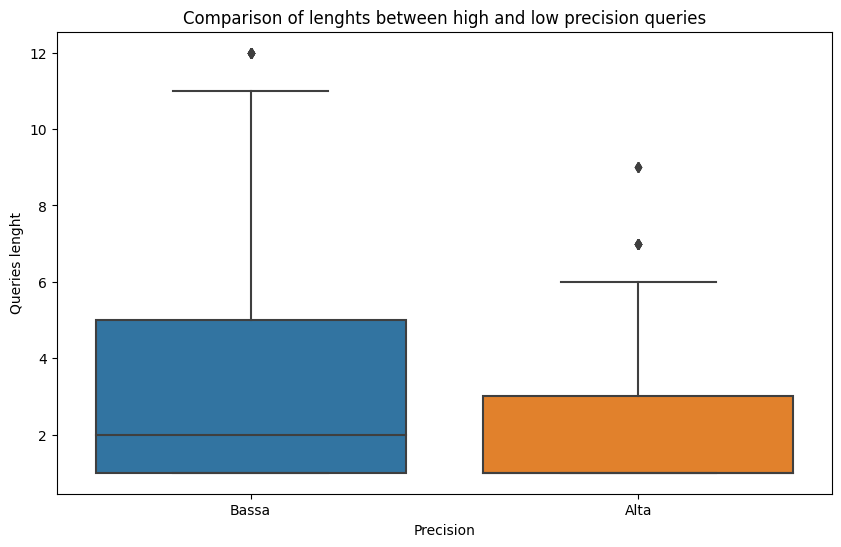

In [37]:
# Compare queries with high precision
high_precision_queries = all_results_df[all_results_df['P_10'] >= 0.8]
high_precision_query_texts = high_precision_queries.merge(df_queries_pt, left_on='query_id', right_on='qid')

# Average lenght of queries with high precision
high_precision_query_texts['query_length'] = high_precision_query_texts['query'].apply(lambda x: len(x.split()))
avg_length_high = high_precision_query_texts['query_length'].mean()

print(f"Average lenght of queries with high precision: {avg_length_high}")

# Visualizzazione 4: Comparison between high and low precision queries
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.concat([
    low_precision_query_texts[['query_length']].assign(precision='Bassa'),
    high_precision_query_texts[['query_length']].assign(precision='Alta')
]), x='precision', y='query_length')
plt.title('Comparison of lenghts between high and low precision queries')
plt.xlabel('Precision')
plt.ylabel('Queries lenght')
plt.show()

Queries with high precision have an average length of 2.43 tokens, shorter than the average for low-precision queries (3.36 tokens). This indicates that overly long queries might introduce noise or ambiguity, lowering precision.

## 4. PART III -  IMPROVING THE RETRIEVAL PERFORMANCES

The query expansion process adds relevant terms to the original queries, enhancing their ability to retrieve related documents. We will use Word2Vec as an example.

In [38]:
# Word2Vec model on title and abstract
text_data = (df_docs['title'].fillna('') + " " + df_docs['text'].fillna('')).apply(lambda x: x.split())
word2vec_model = Word2Vec(sentences=text_data, vector_size=100, window=5, min_count=2, workers=8)

# Function to expand queries
def expand_query(query, model, top_n=3):
    expanded_terms = []
    for term in query.split():
        if term in model.wv:
            similar_terms = model.wv.most_similar(term, topn=top_n)
            expanded_terms.extend([t[0] for t in similar_terms])
    return query + " " + " ".join(expanded_terms)

df_queries_expanded = df_queries_pt.copy()
df_queries_expanded['expanded_query'] = df_queries_expanded['query'].apply(lambda q: expand_query(q, word2vec_model))

print(df_queries_expanded[['query', 'expanded_query']].head())

                                               query  \
0    Do Cholesterol Statin Drugs Cause Breast Cancer   
1                Exploiting Autophagy to Live Longer   
2  How to Reduce Exposure to Alkylphenols Through...   
3           What s Driving America s Obesity Problem   
4               Who Should be Careful About Curcumin   

                                      expanded_query  
0  Do Cholesterol Statin Drugs Cause Breast Cance...  
1  Exploiting Autophagy to Live Longer windows, i...  
2  How to Reduce Exposure to Alkylphenols Through...  
3  What s Driving America s Obesity Problem Novel...  
4  Who Should be Careful About Curcumin Milk lamb...  


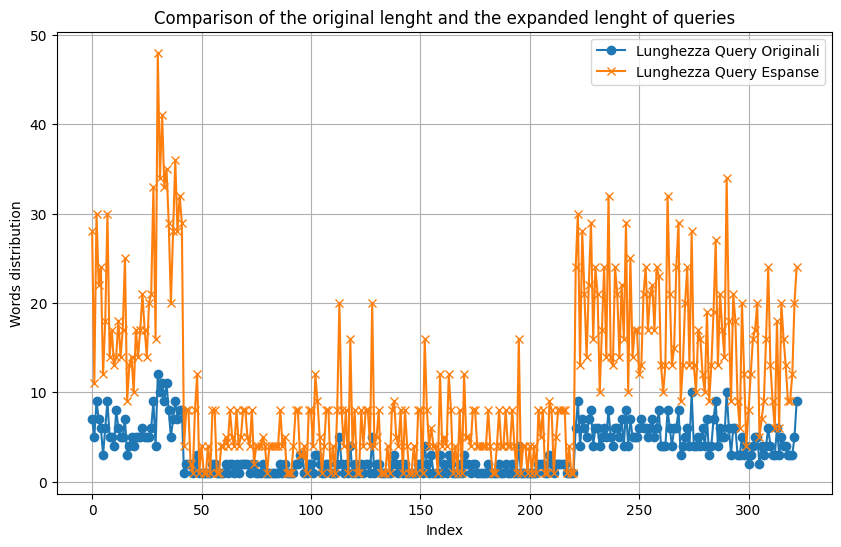

In [39]:
# Comparison of the original lenght and the expanded lenght of queries
df_queries_expanded['original_length'] = df_queries_expanded['query'].apply(lambda q: len(q.split()))
df_queries_expanded['expanded_length'] = df_queries_expanded['expanded_query'].apply(lambda q: len(q.split()))

# Creazione di un grafico per confrontare le lunghezze
plt.figure(figsize=(10, 6))
plt.plot(df_queries_expanded.index, df_queries_expanded['original_length'], label='Lunghezza Query Originali', marker='o')
plt.plot(df_queries_expanded.index, df_queries_expanded['expanded_length'], label='Lunghezza Query Espanse', marker='x')
plt.xlabel('Index')
plt.ylabel('Words distribution')
plt.title('Comparison of the original lenght and the expanded lenght of queries')
plt.legend()
plt.grid(True)
plt.show()

Let's see the five most expanded queries. 

In [40]:
df_queries_expanded['original_word_count'] = df_queries_expanded['query'].apply(lambda x: len(x.split()))
df_queries_expanded['expanded_word_count'] = df_queries_expanded['expanded_query'].apply(lambda x: len(x.split()))

# Difference Between Number of Words
df_queries_expanded['added_words'] = df_queries_expanded['expanded_word_count'] - df_queries_expanded['original_word_count']

# descending order
df_queries_most_expanded = df_queries_expanded.sort_values(by='added_words', ascending=False).head(5)

for index, row in df_queries_most_expanded.iterrows():
    print(f"Original Query: {row['query']}")
    print(f"Expanded Query: {row['expanded_query']}")
    print(f"Words Added: {row['added_words']}")
    print("-" * 80)

Original Query: Can antioxidant rich spices counteract the effects of a high fat meal
Expanded Query: Can antioxidant rich spices counteract the effects of a high fat meal sensible preformed helping phenolic capacity sorbic staple plant starch, chemical substances generated help prove stimulate life their The impact effect influence main Neuroprotective promyelocyte an A Mediterranean low protein fat protein energy fibre dose meal. following
Words Added: 36
--------------------------------------------------------------------------------
Original Query: Didn t another study show carnitine was good for the heart
Expanded Query: Didn t another study show carnitine was good for the heart Statistical test. ANOVA aromatherapy cleaning incomplete objective study, trial demonstrate indicate concluded iron, sensitivity, IL-18 were PFGE. immersion turmeric ingredient unique confounders, Exploration confounding life their The coronary ischaemic ischemic
Words Added: 30
---------------------------

We are going to train again each pipeline in order to see if we can get better results.

In [41]:
df_queries_expanded

,qid,query,expanded_query,original_length,expanded_length,original_word_count,expanded_word_count,added_words
0,PLAIN-2,Do Cholesterol Statin Drugs Cause Breast Cancer,Do Cholesterol Statin Drugs Cause Breast Cance...,7,28,7,28,21
1,PLAIN-12,Exploiting Autophagy to Live Longer,"Exploiting Autophagy to Live Longer windows, i...",5,11,5,11,6
2,PLAIN-23,How to Reduce Exposure to Alkylphenols Through...,How to Reduce Exposure to Alkylphenols Through...,9,30,9,30,21
3,PLAIN-33,What s Driving America s Obesity Problem,What s Driving America s Obesity Problem Novel...,7,22,7,22,15
4,PLAIN-44,Who Should be Careful About Curcumin,Who Should be Careful About Curcumin Milk lamb...,6,24,6,24,18
...,...,...,...,...,...,...,...,...
318,PLAIN-3432,Healthy Chocolate Milkshakes,Healthy Chocolate Milkshakes Eating Swedish Pr...,3,9,3,9,6
319,PLAIN-3442,The Healthiest Vegetables,The Healthiest Vegetables This the A OH-PCBs I...,3,9,3,9,6
320,PLAIN-3452,Bowel Movement Frequency,Bowel Movement Frequency Registration orbital ...,3,12,3,12,9
321,PLAIN-3462,Olive Oil and Artery Function,Olive Oil and Artery Function supplemental acc...,5,20,5,20,15


In [42]:
# 3.1 Data preparation
df_index = pd.DataFrame()
df_index['docno'] = df_docs['doc_id']
df_index['text'] = (df_docs['title'].fillna('') + " " + df_docs['text'].fillna(''))
df_index['text_only'] = (df_docs['text'].fillna(''))

# 3.2 Index creation
index_path = "./index"
indexer = pt.DFIndexer(index_path, overwrite=True)
indexref = indexer.index(df_index["text"], df_index["docno"])
index = pt.IndexFactory.of(indexref)
print("Index created. Number of indexed documents:", index.getCollectionStatistics().getNumberOfDocuments())

# 3.3 Definition of retrieval pipeline
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
def clean_query_text(qtext):
    # Removing special carachters like ? ! : ' ecc.
    qtext = re.sub(r"[^a-zA-Z0-9À-ÖÙ-öù-ÿ\s]", " ", qtext)
    qtext = re.sub(r"\s+", " ", qtext).strip()
    return qtext
df_queries_1 = df_queries_expanded.copy()
df_queries_1["query"] = df_queries_1["expanded_query"].apply(clean_query_text)

# 3.4 Preparing Qrels in PyTerrier format
df_qrels_pt = pd.DataFrame()
df_qrels_pt['qid']   = df_qrels['query_id'].astype(str)
df_qrels_pt['docno'] = df_qrels['doc_id'].astype(str)
df_qrels_pt['label'] = df_qrels['relevance'].astype(int)

df_queries_pt2 = pd.DataFrame()
df_queries_pt2['qid']   = df_queries_expanded['qid'].astype(str)
df_queries_pt2['query'] = df_queries_1['query']

nltk.download('stopwords')

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def apply_stemming(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

Index created. Number of indexed documents: 3633
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
# Pipeline 1: Base (title + text, no stemming, no stopword removal)
df_index_1 = df_index.copy()
index_path_1 = "./index_1"
indexer_1 = pt.DFIndexer(index_path_1, overwrite=True)
indexref_1 = indexer_1.index(df_index_1["text"], df_index_1["docno"])
index_1 = pt.IndexFactory.of(indexref_1)
qe_tfidf_1 = pt.BatchRetrieve(index_1, wmodel="TF_IDF")
qe_bm25_1 = pt.BatchRetrieve(index_1, wmodel="BM25")

# Pipeline 2: Stemming (title + text, stemming)
df_index_2 = df_index.copy()
df_index_2["text"] = df_index_2["text"].apply(apply_stemming)
index_path_2 = "./index_2"
indexer_2 = pt.DFIndexer(index_path_2, overwrite=True)
indexref_2 = indexer_2.index(df_index_2["text"], df_index_2["docno"])
index_2 = pt.IndexFactory.of(indexref_2)
qe_tfidf_2 = pt.BatchRetrieve(index_2, wmodel="TF_IDF")
qe_bm25_2 = pt.BatchRetrieve(index_2, wmodel="BM25")

# Pipeline 3: Stopword Removal (title + text, stopword)
df_index_3 = df_index.copy()
df_index_3["text"] = df_index_3["text"].apply(remove_stopwords)
index_path_3 = "./index_3"
indexer_3 = pt.DFIndexer(index_path_3, overwrite=True)
indexref_3 = indexer_3.index(df_index_3["text"], df_index_3["docno"])
index_3 = pt.IndexFactory.of(indexref_3)
qe_tfidf_3 = pt.BatchRetrieve(index_3, wmodel="TF_IDF")
qe_bm25_3 = pt.BatchRetrieve(index_3, wmodel="BM25")

# Pipeline 4: Only title (title, no stemming, no stopword removal)
df_index_4 = pd.DataFrame()
df_index_4["docno"] = df_docs["doc_id"]
df_index_4["text"] = df_docs["title"].fillna("")
index_path_4 = "./index_4"
indexer_4 = pt.DFIndexer(index_path_4, overwrite=True)
indexref_4 = indexer_4.index(df_index_4["text"], df_index_4["docno"])
index_4 = pt.IndexFactory.of(indexref_4)
qe_tfidf_4 = pt.BatchRetrieve(index_4, wmodel="TF_IDF")
qe_bm25_4 = pt.BatchRetrieve(index_4, wmodel="BM25")

# Pipeline 5: Title + text with lowercasing, stemming, stopword removal
df_index_5 = df_index.copy()
df_index_5["text"] = df_index_5["text"].str.lower()
df_index_5["text"] = df_index_5["text"].apply(remove_stopwords)
df_index_5["text"] = df_index_5["text"].apply(apply_stemming)
index_path_5 = "./index_5"
indexer_5 = pt.DFIndexer(index_path_5, overwrite=True)
indexref_5 = indexer_5.index(df_index_5["text"], df_index_5["docno"])
index_5 = pt.IndexFactory.of(indexref_5)
qe_tfidf_5 = pt.BatchRetrieve(index_5, wmodel="TF_IDF")
qe_bm25_5 = pt.BatchRetrieve(index_5, wmodel="BM25")

# Pipeline 6: text with  no preporcessing
df_index_6 = df_index.copy()
df_index_6["text"] = df_index_6["text_only"]
index_path_6 = "./index_5"
indexer_6 = pt.DFIndexer(index_path_6, overwrite=True)
indexref_6 = indexer_6.index(df_index_6["text"], df_index_6["docno"])
index_6 = pt.IndexFactory.of(indexref_6)
qe_tfidf_6 = pt.BatchRetrieve(index_6, wmodel="TF_IDF")
qe_bm25_6 = pt.BatchRetrieve(index_6, wmodel="BM25")

In [44]:
# Retrieval and evaluation for every pipeline
def evaluate_pipeline(tfidf_pipeline, bm25_pipeline, df_queries_pt2, df_qrels_pt):
    tfidf_results = tfidf_pipeline(df_queries_pt2)
    bm25_results = bm25_pipeline(df_queries_pt2)
    
    metrics = ['map', 'P_10', 'ndcg_cut_10']
    eval_tfidf = pt.Utils.evaluate(tfidf_results, df_qrels_pt, metrics=metrics)
    eval_bm25 = pt.Utils.evaluate(bm25_results, df_qrels_pt, metrics=metrics)
    
    return eval_tfidf, eval_bm25

pipelines = [
    (qe_tfidf_1, qe_bm25_1),
    (qe_tfidf_2, qe_bm25_2),
    (qe_tfidf_3, qe_bm25_3),
    (qe_tfidf_4, qe_bm25_4),
    (qe_tfidf_5, qe_bm25_5),
    (qe_tfidf_6, qe_bm25_6)
]

for i, (tfidf_pipeline, bm25_pipeline) in enumerate(pipelines, start=1):
    eval_tfidf, eval_bm25 = evaluate_pipeline(tfidf_pipeline, bm25_pipeline, df_queries_pt2, df_qrels_pt)
    print(f"=== Pipeline {i} ===")
    print("TF-IDF:", eval_tfidf)
    print("BM25:", eval_bm25)

=== Pipeline 1 ===
TF-IDF: {'map': 0.0987680507754018, 'P_10': 0.1427244582043346, 'ndcg_cut_10': 0.20448163166994612}
BM25: {'map': 0.09995851243686199, 'P_10': 0.1411764705882355, 'ndcg_cut_10': 0.20414911099351213}
=== Pipeline 2 ===
TF-IDF: {'map': 0.09747404090785595, 'P_10': 0.1393188854489166, 'ndcg_cut_10': 0.20248747256876867}
BM25: {'map': 0.0977417862118158, 'P_10': 0.1368421052631581, 'ndcg_cut_10': 0.20041087899905993}
=== Pipeline 3 ===
TF-IDF: {'map': 0.09873953120654583, 'P_10': 0.1427244582043346, 'ndcg_cut_10': 0.20437706994419894}
BM25: {'map': 0.09994912289966264, 'P_10': 0.1411764705882355, 'ndcg_cut_10': 0.2041637264649775}
=== Pipeline 4 ===
TF-IDF: {'map': 0.06663760404391314, 'P_10': 0.10495356037151714, 'ndcg_cut_10': 0.15178830361514958}
BM25: {'map': 0.06607174041794416, 'P_10': 0.1065015479876162, 'ndcg_cut_10': 0.1521626655253207}
=== Pipeline 5 ===
TF-IDF: {'map': 0.09759318472367441, 'P_10': 0.14024767801857602, 'ndcg_cut_10': 0.20325666107868903}
BM25: 

Worse results. Maybe it's better to do neural reranking.

## Neural re-ranking

This code performs neural re-ranking to improve the initial BM25 results. It uses a neural model (e.g., static-retrieval-mrl-en-v1) to encode the query and document texts into dense embeddings. The cosine similarity between the query and document embeddings is computed to re-rank the documents based on their semantic relevance. Finally, the re-ranked results are evaluated using metrics such as MAP, P@10, and nDCG@10 to assess performance improvements.

In [45]:
from sentence_transformers import SentenceTransformer, util

In [70]:
model = SentenceTransformer('tomaarsen/static-retrieval-mrl-en-v1')

modules.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/226 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/670k [00:00<?, ?B/s]

0_StaticEmbedding/tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/125M [00:00<?, ?B/s]

In [72]:
# Funzione for neural re-rank
def neural_rerank(query, documents):
    query_embedding = model.encode(query, convert_to_tensor=True, show_progress_bar=False)
    doc_embeddings = model.encode(documents['text'].tolist(), convert_to_tensor=True, show_progress_bar=False)
    scores = util.pytorch_cos_sim(query_embedding, doc_embeddings).squeeze().tolist()
    documents = documents.copy()
    documents['score'] = scores
    return documents.sort_values(by='score', ascending=False)

# Valutazione per tutte le pipeline di BM25
pipelines = [bm25_1, bm25_2, bm25_3, bm25_4, bm25_5, bm25_6]  # Aggiungi tutte le pipeline BM25
all_reranked_evaluations = []

for i, bm_pipeline in enumerate(pipelines, start=1):
    print(f"Reranking for BM25 Pipeline {i}")

    initial_results = bm_pipeline(df_queries_pt)

    reranked_results = []
    for qid, group in initial_results.groupby('qid'):
        doc_ids = group['docno'].tolist()
        doc_texts = df_docs[df_docs['doc_id'].isin(doc_ids)].copy()

        query_text = df_queries_pt[df_queries_pt['qid'] == qid]['query'].values[0]
        ranked_docs = neural_rerank(query_text, doc_texts)

        ranked_docs['qid'] = qid
        ranked_docs['docno'] = ranked_docs['doc_id']
        reranked_results.append(ranked_docs[['qid', 'docno', 'score']])

    reranked_results_df = pd.concat(reranked_results)

    reranked_eval = pt.Utils.evaluate(
        reranked_results_df[['qid', 'docno', 'score']],
        df_qrels_pt,
        metrics=['map', 'P_10', 'ndcg_cut_10']
    )

    all_reranked_evaluations.append((f"Pipeline {i}", reranked_eval))
    print(f"Performance Neural Re-ranking for Pipeline {i}: {reranked_eval}")

# Stampa i risultati per tutte le pipeline
for pipeline, eval in all_reranked_evaluations:
    print(f"{pipeline}: {eval}")

Reranking for BM25 Pipeline 1
Performance Neural Re-ranking for Pipeline 1: {'map': 0.13920349634820933, 'P_10': 0.22074303405572782, 'ndcg_cut_10': 0.3025523779196539}
Reranking for BM25 Pipeline 2
Performance Neural Re-ranking for Pipeline 2: {'map': 0.13847829587899044, 'P_10': 0.22074303405572782, 'ndcg_cut_10': 0.30232871423409}
Reranking for BM25 Pipeline 3
Performance Neural Re-ranking for Pipeline 3: {'map': 0.13911262675347158, 'P_10': 0.22074303405572782, 'ndcg_cut_10': 0.3025523779196539}
Reranking for BM25 Pipeline 4
Performance Neural Re-ranking for Pipeline 4: {'map': 0.10647802580465929, 'P_10': 0.18390092879257008, 'ndcg_cut_10': 0.2623223615420106}
Reranking for BM25 Pipeline 5
Performance Neural Re-ranking for Pipeline 5: {'map': 0.1383930926699906, 'P_10': 0.22074303405572782, 'ndcg_cut_10': 0.30232871423409}
Reranking for BM25 Pipeline 6
Performance Neural Re-ranking for Pipeline 6: {'map': 0.13812552341698306, 'P_10': 0.21950464396284863, 'ndcg_cut_10': 0.300817429

We can try another bert model to see if it performs better.

In [75]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [76]:
# Funzione for neural re-rank
def neural_rerank(query, documents):
    query_embedding = model.encode(query, convert_to_tensor=True, show_progress_bar=False)
    doc_embeddings = model.encode(documents['text'].tolist(), convert_to_tensor=True, show_progress_bar=False)
    scores = util.pytorch_cos_sim(query_embedding, doc_embeddings).squeeze().tolist()
    documents = documents.copy()
    documents['score'] = scores
    return documents.sort_values(by='score', ascending=False)

# Valutazione per tutte le pipeline di BM25
pipelines = [bm25_1, bm25_2, bm25_3, bm25_4, bm25_5, bm25_6]  # Aggiungi tutte le pipeline BM25
all_reranked_evaluations = []

for i, bm_pipeline in enumerate(pipelines, start=1):
    print(f"Reranking for BM25 Pipeline {i}")

    initial_results = bm_pipeline(df_queries_pt)

    reranked_results = []
    for qid, group in initial_results.groupby('qid'):
        doc_ids = group['docno'].tolist()
        doc_texts = df_docs[df_docs['doc_id'].isin(doc_ids)].copy()

        query_text = df_queries_pt[df_queries_pt['qid'] == qid]['query'].values[0]
        ranked_docs = neural_rerank(query_text, doc_texts)

        ranked_docs['qid'] = qid
        ranked_docs['docno'] = ranked_docs['doc_id']
        reranked_results.append(ranked_docs[['qid', 'docno', 'score']])

    reranked_results_df = pd.concat(reranked_results)

    reranked_eval = pt.Utils.evaluate(
        reranked_results_df[['qid', 'docno', 'score']],
        df_qrels_pt,
        metrics=['map', 'P_10', 'ndcg_cut_10']
    )

    all_reranked_evaluations.append((f"Pipeline {i}", reranked_eval))
    print(f"Performance Neural Re-ranking for Pipeline {i}: {reranked_eval}")

# Stampa i risultati per tutte le pipeline
for pipeline, eval in all_reranked_evaluations:
    print(f"{pipeline}: {eval}")

Reranking for BM25 Pipeline 1
Performance Neural Re-ranking for Pipeline 1: {'map': 0.15513343139798194, 'P_10': 0.24705882352941183, 'ndcg_cut_10': 0.3310662093948829}
Reranking for BM25 Pipeline 2
Performance Neural Re-ranking for Pipeline 2: {'map': 0.15431866508695505, 'P_10': 0.24705882352941183, 'ndcg_cut_10': 0.331206118111722}
Reranking for BM25 Pipeline 3
Performance Neural Re-ranking for Pipeline 3: {'map': 0.1550830891936685, 'P_10': 0.24705882352941183, 'ndcg_cut_10': 0.3310662093948829}
Reranking for BM25 Pipeline 4
Performance Neural Re-ranking for Pipeline 4: {'map': 0.11794480935820309, 'P_10': 0.20990712074303414, 'ndcg_cut_10': 0.2903563777942424}
Reranking for BM25 Pipeline 5
Performance Neural Re-ranking for Pipeline 5: {'map': 0.15423943918993374, 'P_10': 0.24705882352941183, 'ndcg_cut_10': 0.331206118111722}
Reranking for BM25 Pipeline 6
Performance Neural Re-ranking for Pipeline 6: {'map': 0.15392948690465064, 'P_10': 0.24520123839009292, 'ndcg_cut_10': 0.3289055

The all-MiniLM-L6-v2 outperforms static-retrieval-mrl-en-v1 in all pipelines. It provides better results for MAP, P@10, and nDCG@10, showcasing its strong semantic representation capabilities. All MiniLM also consistently outperform TF-IDF and BM25 across all pipelines, with higher values for MAP, P@10, and nDCG@10.

export files for ASPIRE

In [1]:
# Esporta i risultati di tutte le pipeline TF-IDF e BM25
for i, (tfidf_pipeline, bm25_pipeline) in enumerate(pipelines, start=1):
    # Recupera i risultati per la pipeline corrente
    tfidf_results = tfidf_pipeline(df_queries_pt)
    bm25_results = bm25_pipeline(df_queries_pt)
    
    # Salva i risultati TF-IDF
    tfidf_results.to_csv(f'tfidf_pipeline_{i}.txt', sep='\t', index=False, header=False)
    
    # Salva i risultati BM25
    bm25_results.to_csv(f'bm25_pipeline_{i}.txt', sep='\t', index=False, header=False)

# Esporta i risultati del neural re-ranking per tutte le pipeline
all_reranked_results = []

for i, reranked_results_df in enumerate(reranked_results_per_pipeline, start=1):
    # Salva i risultati di ogni pipeline in un file separato
    output_file = f'neural_reranking_pipeline_{i}.txt'
    reranked_results_df.to_csv(output_file, sep='\t', index=False, header=False)
    all_reranked_results.append(reranked_results_df)

# Esporta le query e i Qrels
queries_output_file = 'queries.txt'
qrels_output_file = 'qrels.txt'

df_queries_pt.to_csv(queries_output_file, sep='\t', index=False, header=False)
df_qrels_pt.to_csv(qrels_output_file, sep='\t', index=False, header=False)

print("Esportazione completata. I file sono stati salvati nella directory corrente.")

NameError: name 'pipelines' is not defined